In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import argparse
from node2vec import Node2Vec

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def read_dimacs_cnf(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("c"):
                continue
            if line.startswith("p cnf"):
                num_vars, num_clauses = map(int, line.strip().split()[2:])
            else:
                clause = list(map(int, line.strip().split()[:-1]))
                clauses.append(clause)
    return num_vars, clauses

def visualize_graph(clauses):
    G = nx.Graph()
    for clause in clauses:
        for literal in clause:
            G.add_node(abs(literal))  # Dodanie węzłów dla zmiennych
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))  # Dodanie krawędzi między zmiennymi w tej samej klauzuli
    pos = nx.spring_layout(G)  # Ustalenie układu wizualizacji
    nx.draw(G, pos, with_labels=True, node_size=500)
    plt.show()

def generate_node_embeddings(clauses):
    G = nx.Graph()
    for clause in clauses:
        for literal in clause:
            G.add_node(abs(literal))
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))

    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    return model, G

In [30]:
nazwa_pliku = "DIMACS_files/turbo_easy/example.cnf"
nazwa_pliku_1 = "DIMACS_files/turbo_easy/example_1.cnf"

num_vars, clauses = read_dimacs_cnf(nazwa_pliku)
num_vars_1, clauses_1 = read_dimacs_cnf(nazwa_pliku_1)
print(num_vars)
print(clauses)
print(num_vars_1)
print(clauses_1)

4
[[-1, -2, 3], [2, 3], [1, -3, 4]]
60
[[39, 40, 1], [-39, -40, 1], [39, -40, -1], [-39, 40, -1], [1, 41, 2], [-1, -41, 2], [1, -41, -2], [-1, 41, -2], [2, 42, 3], [-2, -42, 3], [2, -42, -3], [-2, 42, -3], [3, 43, 4], [-3, -43, 4], [3, -43, -4], [-3, 43, -4], [4, 44, 5], [-4, -44, 5], [4, -44, -5], [-4, 44, -5], [5, 45, 6], [-5, -45, 6], [5, -45, -6], [-5, 45, -6], [6, 46, 7], [-6, -46, 7], [6, -46, -7], [-6, 46, -7], [7, 47, 8], [-7, -47, 8], [7, -47, -8], [-7, 47, -8], [8, 48, 9], [-8, -48, 9], [8, -48, -9], [-8, 48, -9], [9, 49, 10], [-9, -49, 10], [9, -49, -10], [-9, 49, -10], [10, 50, 11], [-10, -50, 11], [10, -50, -11], [-10, 50, -11], [11, 51, 12], [-11, -51, 12], [11, -51, -12], [-11, 51, -12], [12, 52, 13], [-12, -52, 13], [12, -52, -13], [-12, 52, -13], [13, 53, 14], [-13, -53, 14], [13, -53, -14], [-13, 53, -14], [14, 54, 15], [-14, -54, 15], [14, -54, -15], [-14, 54, -15], [15, 55, 16], [-15, -55, 16], [15, -55, -16], [-15, 55, -16], [16, 56, 17], [-16, -56, 17], [16, -56, 

In [31]:
model, G = generate_node_embeddings(clauses)
node_1_embedding = model.wv.get_vector(str(1))
print("Embedding for node 1:", node_1_embedding)

Computing transition probabilities: 100%|██████████| 4/4 [00:00<00:00, 2668.13it/s]

Embedding for node 1: [-0.0229034   0.01702523  0.09693831  0.19519852 -0.11370695 -0.11724223
  0.10625061  0.31068692 -0.03428717 -0.12135386  0.16804671  0.04545498
  0.19550468  0.0873332  -0.20613803 -0.14155443 -0.08047812  0.17582451
 -0.016565   -0.04557245  0.09932123  0.11492666  0.31228027 -0.19648997
  0.07689258  0.18806413 -0.07332975  0.08782377 -0.03875503 -0.04386108
  0.02038634  0.04548222 -0.01208423 -0.22768138  0.03181886  0.09192465
 -0.0747577   0.06278513  0.1940725  -0.08005142 -0.01503397 -0.01203202
 -0.20119594 -0.03668553 -0.01006653 -0.02385647 -0.09414804 -0.07332388
 -0.1341764   0.22801836 -0.01814828  0.21073139  0.02718034  0.20352438
  0.0944677  -0.13795692  0.0614107  -0.18280385  0.10524403 -0.14037742
  0.04185143 -0.05860216 -0.21054065 -0.09309189]


In [32]:
node_2_embedding = model.wv.get_vector(str(4))
print("Embedding for node 2:", node_2_embedding)

Embedding for node 2: [-0.02226372  0.02606846  0.1277418   0.16356604 -0.10319816 -0.14134374
  0.09545802  0.29165912 -0.00824319 -0.07127415  0.17850544  0.07086586
  0.19777116  0.07079355 -0.22515945 -0.11259127 -0.09016038  0.19193898
 -0.01706376 -0.07305042  0.12469125  0.11365011  0.31698957 -0.2111292
  0.08733076  0.17990479 -0.08425952  0.10944361 -0.02473266 -0.02624617
 -0.01357369  0.04890873 -0.00673333 -0.19598903  0.01835484  0.05798886
 -0.03923695  0.06902003  0.20233534 -0.11816303 -0.01873253  0.02640702
 -0.21797962 -0.08261722  0.0153161   0.01699181 -0.09371852 -0.06753185
 -0.139705    0.19688044 -0.01306718  0.17811494 -0.02108733  0.1919228
  0.1209392  -0.15578267  0.05522656 -0.1738121   0.07887813 -0.1398256
  0.02543088 -0.08519106 -0.19400339 -0.11339782]


In [33]:
for node, _ in model.wv.most_similar('4'):
    print((node, _))

('2', 0.9930354356765747)
('3', 0.9927011728286743)
('1', 0.9848535656929016)


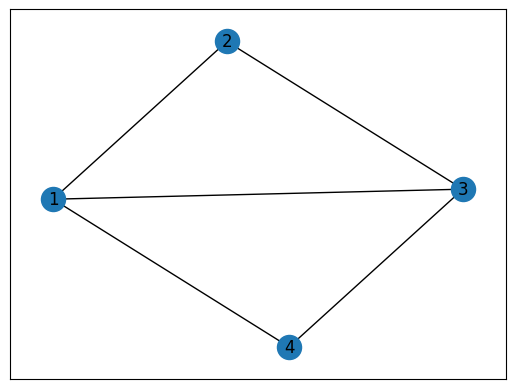

In [34]:
nx.draw_networkx(G)

In [36]:
model_1, G1 = generate_node_embeddings(clauses_1)

Computing transition probabilities: 100%|██████████| 60/60 [00:00<00:00, 2857.51it/s]


In [37]:
for node, _ in model_1.wv.most_similar('1'):
    print((node, _))

('38', 0.9585421681404114)
('39', 0.9540902972221375)
('41', 0.9521230459213257)
('40', 0.9518646597862244)
('2', 0.91828453540802)
('37', 0.9028995633125305)
('42', 0.8776572942733765)
('3', 0.8363995552062988)
('36', 0.800519585609436)
('43', 0.7376021146774292)


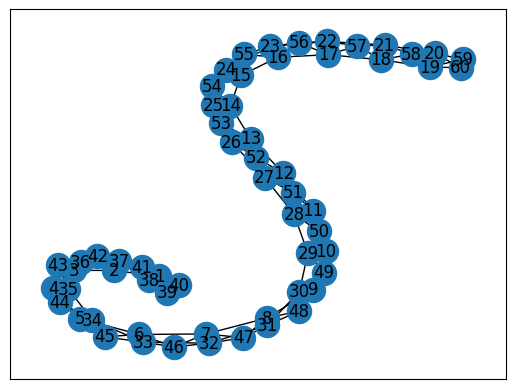

In [42]:
nx.draw_networkx(G1)

In [41]:
node_IDs = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors
print(node_IDs)
print(node_embeddings)

['38', '34', '1', '45', '19', '6', '37', '20', '41', '58', '56', '22', '54', '33', '46', '21', '30', '16', '44', '49', '29', '43', '48', '8', '9', '12', '5', '23', '7', '17', '52', '57', '4', '10', '35', '36', '42', '2', '15', '26', '25', '32', '31', '14', '47', '24', '18', '3', '53', '55', '13', '11', '27', '50', '28', '51', '40', '39', '59', '60']
[[-0.24852538 -0.0404568   0.04351164 ... -0.5927737   0.17431393
  -0.08089081]
 [ 0.0770636   0.18791622 -0.11316011 ... -0.2141235  -0.04288598
   0.02038513]
 [-0.22555047  0.11688668  0.13959098 ... -0.5759298   0.11564046
   0.05518407]
 ...
 [-0.10168109  0.00220793 -0.02367179 ... -0.5787794   0.13106859
   0.11264338]
 [-0.21160722  0.02795111  0.06480774 ... -0.5417254  -0.09055955
   0.3727569 ]
 [-0.17847331  0.0641359   0.05550005 ... -0.49156    -0.10960364
   0.20427382]]
